<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL2_Object_detection/04_Oxford_pet_localiazation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Oxford-IIIT Pet Dataset
- https://www.robots.ox.ac.uk/~vgg/data/pets/
- 37개 카테고리의 개, 고양이 품종 데이터셋. 각 클래스 별로 대략 200여장의 이미지를 제공한다.
- 파일명에 품종이 포함되어 있어 classification 데이터셋을 만들 수 있다.
- 3686개 이미지에대한 annotation 파일을 제공한다.
    - bounding box는 각 pet의 얼굴을 가리킨다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# library import
import os
 
import re
import random
import xml.etree.ElementTree as et
from PIL import Image
 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
 
print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


# Oxford Pet Dataset
- 파일명
    - 품종명_번호.jpg
    - 대문자로 시작: 고양이, 소문자로 시작: 개
    - Egyptian_Mau_1.jpg, american_bulldog_10.jpg

### 데이터셋 다운로드

In [3]:
import gdown
url = 'https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT
To: /content/oxford_pet.zip
100%|██████████| 811M/811M [00:03<00:00, 228MB/s]


'oxford_pet.zip'

In [4]:
## 압축풀기 (!unzip 압축파일명 -d 디렉토리)
!unzip -q oxford_pet.zip -d oxford_pet

## 압축풀기2
# from zipfile import ZipFile
# ZipFile(파일명).extractall(directory)
# ZipFile('oxford_pet.zip').extractall(oxford_pet)

In [5]:
## 압축이 풀린 directory 확인
!ls -al oxford_pet

total 292
drwxr-xr-x 4 root root   4096 Dec 17 00:46 .
drwxr-xr-x 1 root root   4096 Dec 17 00:46 ..
drwxr-xr-x 4 root root   4096 Dec 17 00:46 annotations
drwxr-xr-x 2 root root 286720 Dec 17 00:46 images


In [6]:
# 경로 설정
base_dir = '/content/oxford_pet' #데이터셋 기본경로
image_dir = os.path.join(base_dir, 'images') # image 디렉토리 경로
bbox_dir = os.path.join(base_dir, 'annotations', 'xmls') #annotation 파일경로

In [ ]:
# os.listdir(directory) # directory 경로 아래 파일/하위 디렉토리들의 이름을 list로 반환
os.listdir(image_dir)

In [8]:
# 이미지 파일명 조회
# image_dir의 파일명들 중에서 .jpg 파일명만 list에 담기
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))
 
image_files[:3]

7390


['japanese_chin_126.jpg', 'British_Shorthair_258.jpg', 'pomeranian_199.jpg']

In [9]:
# annotation 파일 경로
# annotation 파일명 리스트
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))
bbox_files[:3]

3686


['english_setter_108.xml', 'Persian_10.xml', 'Ragdoll_111.xml']

# Pillow
- Image객체.mode - 컬러모드 조회
  - L: Gray scale (흑백)
  - P: RGB가 아닌 컬러
  - RGB, RGBA(투명도)

In [10]:
# 이미지 파일중 RGB가 아닌 이미지 파일과 그 파일에 대한 annotation파일 제거
remove_image_cnt = 0 # 삭제된 파일 개수 확인
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file) # image 디렉토리/파일명 => 파일경로
    bbox_file = os.path.splitext(image_file)[0]+'.xml' # 이미지 파일의 xml 파일명
    bbox_path = os.path.join(bbox_dir, bbox_file) # annotation 파일경로
    
    image = Image.open(image_path) # Pillow를 이용해 이미지 로딩
    image_mode = image.mode # 컬러모드
    if image_mode != 'RGB': # RGB모드가 아니면 삭제 (image, annotation파일)
        image = np.asarray(image) # image shape확인을 위해 ndarray로 변환 (삭제를 위해서는 필요없음)
        print(image_file, image_mode, image.shape)

        os.remove(image_path) # 이미지 파일 삭제
        remove_image_cnt += 1
        # annotation파일 삭제
        if os.path.isfile(bbox_path): # annotation 파일이 없을 수 있으므로 있는지 확인 후 삭제
            print(bbox_path)
            os.remove(bbox_path)

Abyssinian_34.jpg P (202, 250)
Egyptian_Mau_14.jpg RGBA (800, 582, 4)
Egyptian_Mau_129.jpg L (325, 299)
/content/oxford_pet/annotations/xmls/Egyptian_Mau_129.xml
Egyptian_Mau_167.jpg P (275, 183)
Egyptian_Mau_145.jpg P (188, 216)
staffordshire_bull_terrier_22.jpg L (500, 364)
Egyptian_Mau_177.jpg P (175, 246)
Egyptian_Mau_191.jpg P (214, 300)
Abyssinian_5.jpg RGBA (150, 200, 4)
Egyptian_Mau_186.jpg RGBA (275, 183, 4)
staffordshire_bull_terrier_2.jpg L (282, 500)
Egyptian_Mau_139.jpg P (250, 350)


In [11]:
remove_image_cnt

12

In [12]:
# 삭제후 image, annotation 파일 목록 다시만들기
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']

len(image_files), len(bbox_files)

(7378, 3685)

### class dictionary 생성

In [13]:
# 클래스 딕셔너리 리스트로 만들기
class_list = set() # 중복 허용 안함
for image_file in image_files:
    # Abyssinian_34.jpg
    file_name = os.path.splitext(image_file)[0] # 파일명, 확장자 중에 파일명만 추출: Abyssinian_34
    class_name = re.sub('_\d+', '', file_name) # '_(num)' => '' (삭제하기): Abyssinian
    class_list.add(class_name) # set에 추가    
class_list = list(class_list) 
class_list.sort()  
print(len(class_list))

37


In [16]:
class_list # index -> class

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [14]:
# 리스트 딕셔너리로 만들기: class->index로 반환하는 것.
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

# train/validation 데이터셋 만들기

## TFRecord 만들기

In [17]:
IMG_SIZE = 224 # model에 넣어줄 때의 image_size (224, 224, 3)
N_BBOX = len(bbox_files) # annotation 파일의 개수
N_TRAIN = 3000 # train set의 개수 (annotation파일이 있는 이미지들이 대상: 3685)
N_VAL = N_BBOX - N_TRAIN # Validation set 개수

In [19]:
## TFRecord 저장할 directory 생성
tfr_dir = os.path.join(base_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

## tfrecord 파일 경로 정의
tfr_train_dir = os.path.join(tfr_dir, 'oxford_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'oxford_val.tfr')
print(tfr_train_dir)
print(tfr_val_dir)

/content/oxford_pet/tfrecord/oxford_train.tfr
/content/oxford_pet/tfrecord/oxford_val.tfr


In [20]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [21]:
# The following functions can be used to convert a value to a type compatible with tf.Example.
 
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
 
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [22]:
# train, validation 데이터셋의 index 설정

# 데이터 섞기
shuffle_list = list(range(N_BBOX)) # index
random.shuffle(shuffle_list) # index 섞기 (섞인 list 반환)
# 분할
train_idx_list = shuffle_list[:N_TRAIN] # train set으로 사용할 데이터의 index들 (앞의 3000개)
val_idx_list = shuffle_list[N_TRAIN:] # val set으로 사용할 데이터들의 index들 (나머지)

In [23]:
# Train TFRecord 생성
for idx in train_idx_list:
    bbox_file = bbox_files[idx] # idx의 annotation파일명 조회
    bbox_path = os.path.join(bbox_dir, bbox_file) # annotation 파일의 경로(dir/file명)

    # et: ElementTree
    # et.parse(xml파일의 경로) / root태그에서부터 원하는 값을 가진 태그를 파일경로 형식으로 찾아감
    tree = et.parse(bbox_path) # tree: root
    # tag객체.text: 태그의 content(값)을 조회
    # tag객체.find(): 하위태그 찾기
    # xmin, ymin: bounding box의 좌상단 좌표
    # xmax, ymax: bounding box의 우하단 좌표
    width = float(tree.find('./size/width').text) # .: root 하위 size 태그 하위의 width의 내용값을 조회
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    #X, Y Center 좌표
    xc = (xmin + xmax)/2.
    yc = (ymin + ymax)/2.

    # 이미지의 size대비 비율로 저장
    x = xc/width
    y = yc/height

    # boundbox의 width, height -> 이미지 size 대비 비율로 반환
    w = (xmax - xmin)/width
    h = (ymax - ymin)/height

    # 이미지 조회
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file) # 이미지 파일 경로 (디렉토리, 파일명)
    image = Image.open(image_path) # Pillow 이용해서 이미지 로딩
    image = image.resize((IMG_SIZE, IMG_SIZE)) # (224, 224)로 resize
    bimage = image.tobytes() # 이미지 객체를 byte타입으로 변환
 
    # classification을 위한 label 조회
    # 품종라벨 조회 - 파일명
    class_name = re.sub('_\d+', '', file_name) # 품종_번호: 번호제거 - 품종 class 이름
    class_num = class2idx[class_name] # 품종 index
    
    # 개/고양이 이진분류 라벨 생성 - 파일명 대문자로 시작: 고양이 / 소문자로 시작: 개
    # 개 = 0 / 고양이 = 1
    if file_name[0].islower(): # 첫글자가 소문자인지?
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    # Example 생성
    example = tf.train.Example(features=tf.train.Features(feature={
          'image': _bytes_feature(bimage),
          'cls_num': _int64_feature(class_num),
          'bi_cls_num': _int64_feature(bi_cls_num),
          'x': _float_feature(x),
          'y': _float_feature(y),
          'w': _float_feature(w),
          'h': _float_feature(h)
    }))
    # tfrecord 파일에 Example을 출력
    writer_train.write(example.SerializeToString())

writer_train.close()

In [24]:
# Validation TFRecord 생성
for idx in val_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
 
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('.size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
 
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
 
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
 
    if file_name[0].islower():
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    
    example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

# Localization 모델 학습
- 물체가 있는 위치를(cx, cy, bb_width, bb_height) 추론하는 모델

In [25]:
## Hyper Parameters
LEARNING_RATE = 0.0001
N_CLASS = len(class_list)
N_EPOCHS = 10
N_BATCH = 40
IMG_SIZE = 224

steps_per_epoch = N_TRAIN // N_BATCH # drop_remainder=True이기 때문에 => 몫나누기
validation_steps = int(np.ceil(N_VAL / N_BATCH)) # drop_remainder=False이기 때문에 => ceil(올림)

print(steps_per_epoch, validation_steps)

75 18


In [26]:
# TFRecord에 저장된 Dataset의 하나의 Data(Example)를 parsing(X, y깂들을 추출)하는 함수
def _parse_function(tfrecord_serialized):
    """
    [매개변수]
        tfrecord_serialized: parsing할 1개의 serialize된 Example data
    [반환값] 
        튜플 (image, ground truth)
        ground true: [x, y, w, h]
    """
    # serialize된 Example에 저장된 Featrue들을 저장할 빈 Feature들을 가진 딕셔너리 생성
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    # Example 객체 생성 (역직렬화)
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    # Example에서 image 추출
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. # 0 ~ 1로 정규화
    
    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    grount_truth = tf.stack([x, y, w, h], -1)
    
    # X: image, y:[x, y, w, h]
    return image, grount_truth

In [27]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)

## num_parellel_calls=tf.data.experimental.AUTOTUNE: 병렬 처리 - 여러개 example을 반환하는 작업
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## prefetch(): 현재 배치를 학습하는 동안에 다음 배치에서 사용할 배치를 미리 읽어오도록 처리
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [28]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

### Trainset의 데이터 읽어서 bounding box 확인

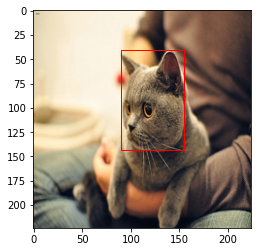

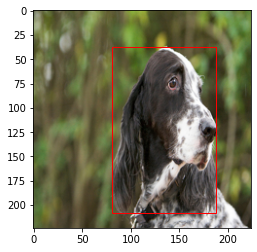

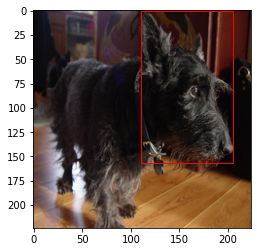

In [29]:
for image, gt in val_dataset.take(3):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0] # center x
    y = gt[:,1] # center y
    w = gt[:,2] # bounding box width
    h = gt[:,3] # bounding box height
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    # xmin, ymin, bb_w, bb_h에 image size(224)를 곱해서 원래 크기로 변환
    rect_x = int(xmin * IMG_SIZE) 
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    # Rectangle((좌상단 x, y), width, height) => 이미지에 사각형을 그리는 matplotlib 함수
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

## 모델 생성 및 학습


In [30]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [32]:
def create_l_model():
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model = keras.models.Sequential()
    model.add(resnet101v2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 출력: [x, y, w, h] -> unit수=4
    # Regression(회귀)
    # y: 0 ~ 1 정규화 -> activation 함수를 sigmoid를 사용해서 0 ~ 1 사이의 값이 출력되도록 처리
    model.add(Dense(4, activation='sigmoid'))
    return model

In [33]:
model = create_l_model()
model.summary()

171327488/171317808 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                       

In [34]:
# 모델 컴파일
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizers.Adam(lr_schedule), loss="mse")

In [35]:
# call_back 생성
# best model 저장, early stopping
filepath = r'/content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model'
mc_callback = keras.callbacks.ModelCheckpoint(filepath, 'val_loss',verbose=1, save_best_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[mc_callback, es_callback])

Epoch 1/10
     75/Unknown - 46s 330ms/step - loss: 0.0419
Epoch 00001: val_loss improved from inf to 0.05484, saving model to /content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


75/75 [==============================] - 105s 1s/step - loss: 0.0419 - val_loss: 0.0548
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00002: val_loss improved from 0.05484 to 0.03794, saving model to /content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


75/75 [==============================] - 85s 1s/step - loss: 0.0157 - val_loss: 0.0379
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.0098
Epoch 00003: val_loss improved from 0.03794 to 0.01060, saving model to /content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/saved_models/oxford_pet_localization_resnet101v2_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


75/75 [==============================] - 82s 1s/step - loss: 0.0098 - val_loss: 0.0106
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.0091
Epoch 00004: val_loss did not improve from 0.01060
75/75 [==============================] - 28s 358ms/step - loss: 0.0091 - val_loss: 0.0136
Epoch 5/10
75/75 [==============================] - ETA: 0s - loss: 0.0092
Epoch 00005: val_loss did not improve from 0.01060
75/75 [==============================] - 28s 357ms/step - loss: 0.0092 - val_loss: 0.1151
Epoch 6/10
75/75 [==============================] - ETA: 0s - loss: 0.0076
Epoch 00006: val_loss did not improve from 0.01060
75/75 [==============================] - 28s 357ms/step - loss: 0.0076 - val_loss: 0.0108
Epoch 7/10
75/75 [==============================] - ETA: 0s - loss: 0.0063
Epoch 00007: val_loss did not improve from 0.01060
75/75 [==============================] - 28s 357ms/step - loss: 0.0063 - val_loss: 0.0355
Epoch 8/10
75/75 [==============================]

## 확인

In [36]:
# 미리학습한 모델 다운로드
import gdown  
url = 'https://drive.google.com/uc?id=1-46XMDhIrkBnvYKNN_VGlhPlyu-Bn3tF'
fname = 'oxford_pet_localization_resnet101.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-46XMDhIrkBnvYKNN_VGlhPlyu-Bn3tF
To: /content/oxford_pet_localization_resnet101.tar.gz
100%|██████████| 475M/475M [00:05<00:00, 90.5MB/s]


'oxford_pet_localization_resnet101.tar.gz'

In [37]:
!mkdir models

In [38]:
!tar -zxvf oxford_pet_localization_resnet101.tar.gz -C  models

./
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001
./assets/
./keras_metadata.pb
./saved_model.pb


In [39]:
# 저장된 모델 load
filepath = '/content/models'
saved_model = keras.models.load_model(filepath)

In [40]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

### Bounding Box 그리기

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


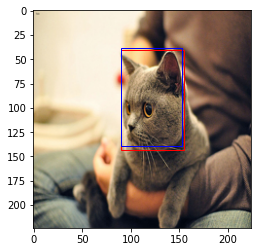

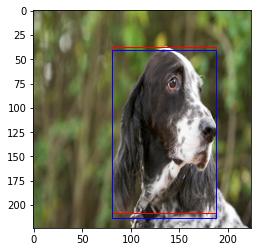

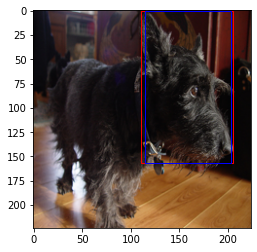

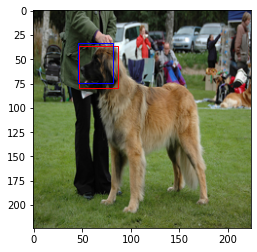

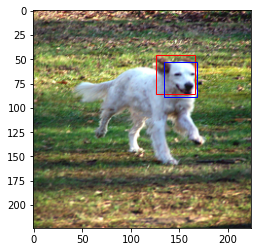

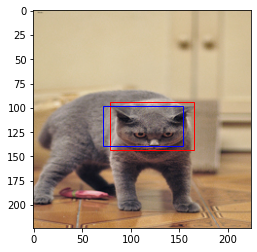

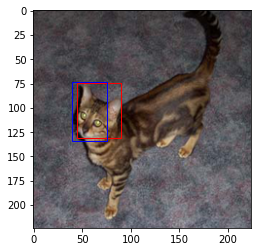

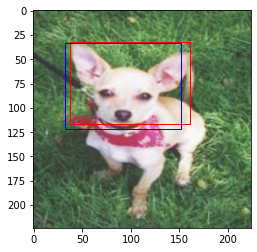

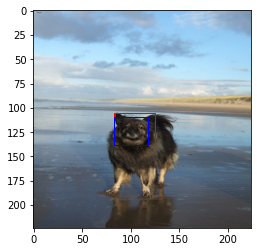

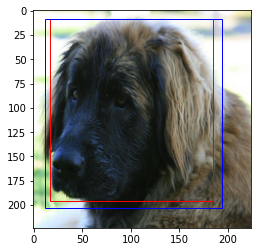

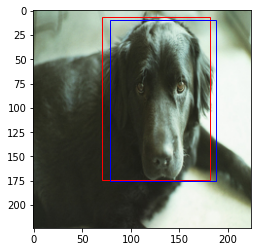

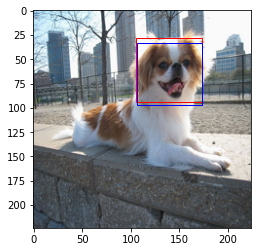

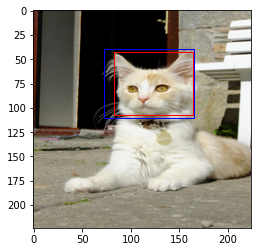

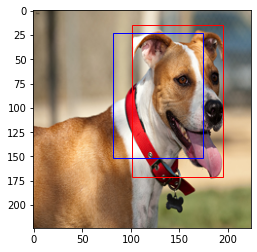

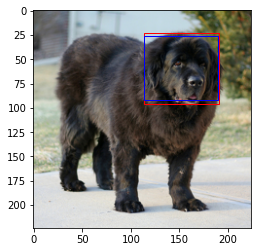

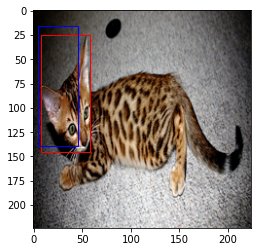

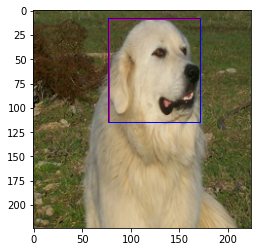

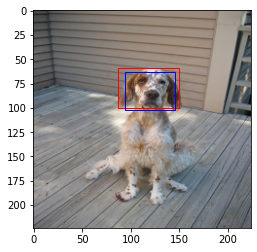

In [41]:
# 예측한 bounding box와 ground truth box를 image에 같이 표시
# 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
# validation dataset에서 step(batc)별로 한장씩 골라서 그리기 (배치(40장)중 한 장)
for val_data, val_gt in val_dataset.take(num_imgs):

    # ground truth의 x, y, w, h
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    
    # 좌상단 x, y 좌표 계산
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.

    # (224, 224) 사이즈 기준으로 원래 크기 복원
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    # ground truth의 bbox그리기 (red)
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    # model을 이용해 x, y, w, h 추론
    prediction = saved_model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    # 추론 결과 bbox그리기 (blue)
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    
    plt.imshow(val_data[idx])
    plt.show()

### IoU확인하기

In [42]:
## Valiation set의 IOU 계산
avg_iou = 0 # 평균 IoU 값을 저장할 변수
num_imgs = validation_steps
res = N_VAL % N_BATCH # 마지막 배치의 데이터수
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    
    flag = (i == validation_steps-1) # 마지막 step 데이터들에 대한 IoU 계산인지 체크
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = saved_model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
        if(flag): # True: 마지막 step(배치)
            if idx == res: # 마지막 data에 대한 처리 끝남 => 반복문 종료
                flag = False
                break  
        
        # target bbox 좌상단, 우하단 좌표
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        # pred. bbox 좌상단, 우하단 좌표
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        # 두 bbox가 겹치지 않는 경우, IoU 계산 안함(continue)
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin

        # 중첩 box의 width, height
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
 
        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))

        avg_iou += iou / N_VAL

print(avg_iou)

0.8158543770805844


# Classification을 추가하여 Multi-task Learning으로 Localization 학습하기

- **고양이/개 2개 class로 classification**

In [43]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [44]:
# tfrecord 파싱 함수(classification + localization)
# image, ground_True[label, x, y, w, h]
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.float32) # 품종 (사용x)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32) # 개=0/고양이=1(사용o)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    ground_truth = tf.stack([bi_cls_label, x, y, w, h], -1) 
    
    return image, ground_truth

In [45]:
#Train Dataset 생성
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [46]:
#Validation Dataset 생성
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

In [47]:
def create_cl_model():    
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(resnet101v2.output)

    # 분류를 위한 레이어 연결
    dense_b1_1 = Dense(256)(gap)
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)
    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)
    output1 = Dense(2, activation='softmax', name='output1')(relu_b1_6)

    # bbox 좌표를 찾기 위한 레이어 연결
    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)
    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)
    output2 = Dense(4, activation='sigmoid', name='output2')(relu_b2_6)
    
    concat = Concatenate(name='finaly_output')([output1, output2])
    return keras.Model(inputs=resnet101v2.input, outputs=concat)

In [48]:
model = create_cl_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [49]:
keras.utils.plot_model(model, show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.781935 to fit



In [50]:
# Loss 함수 구현
# 함수 (정답, 예측)
# 반환값은 loss 반환

# target (N, 5) - label, x, y, w, h
# prediction (N, 6) - 0확률, 1확률, x, y, w, h
def loss_fn(y_true, y_pred):
    # 정답의 label 조회 - labelencoding
    cls_labels = tf.cast(y_true[:,:1], tf.int64)
    # 정답의 bbox의 좌표 조회
    loc_labels = y_true[:,1:]
    # 추론값의 label 조회 - onehotencoding
    cls_preds = y_pred[:,:2]
    # 추론값의 bbox 좌표 조회
    loc_preds = y_pred[:,2:]
    # 분류 loss
    cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)
    # 좌표 loss
    loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    return cls_loss + 5*loc_loss # 좌표 loss에 가중치(5)를 줌

In [51]:
# 모델 컴파일
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
# loss를 위에서 정의한 loss함수로 설정
model.compile(optimizers.Adam(lr_schedule), loss=loss_fn)

In [52]:
# 학습
filepath2 = r'/content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'
mc_callback = keras.callbacks.ModelCheckpoint(filepath2, 'val_loss',verbose=1, save_best_only=True, save_weights_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=[mc_callback, es_callback])

Epoch 1/2
     75/Unknown - 37s 333ms/step - loss: 0.4493
Epoch 00001: val_loss improved from inf to 0.43917, saving model to /content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt
75/75 [==============================] - 44s 427ms/step - loss: 0.4493 - val_loss: 0.4392
Epoch 2/2
75/75 [==============================] - ETA: 0s - loss: 0.1238
Epoch 00002: val_loss improved from 0.43917 to 0.15559, saving model to /content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt
75/75 [==============================] - 31s 397ms/step - loss: 0.1238 - val_loss: 0.1556


# 확인

### 미리 학습된 weights 가져오기 평가하기

In [53]:
# 미리학습한 모델 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo'
fname = 'oxford_pet_classification_localization_resnet101_weight.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo
To: /content/oxford_pet_classification_localization_resnet101_weight.tar.gz
100%|██████████| 481M/481M [00:03<00:00, 152MB/s]


'oxford_pet_classification_localization_resnet101_weight.tar.gz'

In [54]:
!mkdir weights

In [55]:
# 압축풀기
!tar -zxvf oxford_pet_classification_localization_resnet101_weight.tar.gz -C  /content/weights

oxford_pet_localization_classification_resnet101v2_weights/
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.index
oxford_pet_localization_classification_resnet101v2_weights/checkpoint
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.data-00000-of-00001


In [56]:
# 마지막으로 저장된 checkpoint 경로 확인
# latest_checkpoint (학습된 weight가 저장된 directory): 가장 마지막으로 저장된 파일의 이름 반환
best_weight_path = tf.train.latest_checkpoint('/content/weights/oxford_pet_localization_classification_resnet101v2_weights')
best_weight_path

'/content/weights/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'

In [57]:
# 저장된 weight load 
saved_model2 = create_cl_model()
saved_model2.load_weights(best_weight_path)

### Bounding Box 확인

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


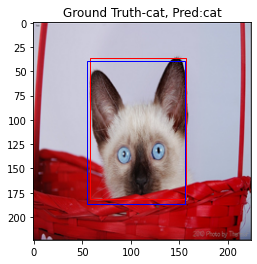

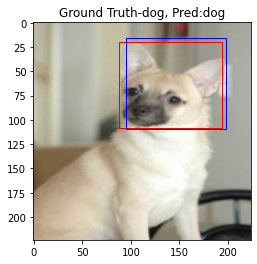

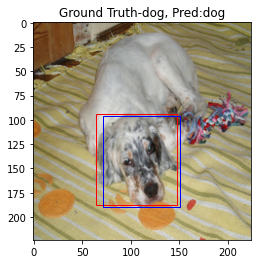

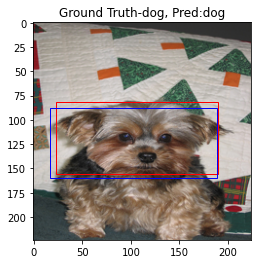

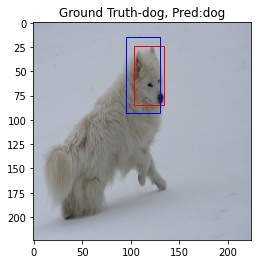

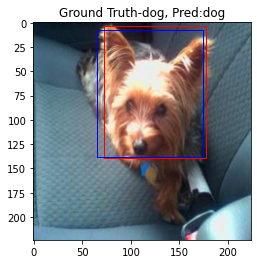

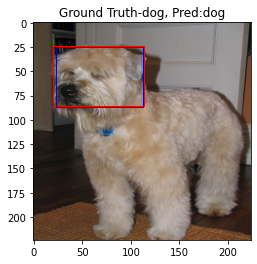

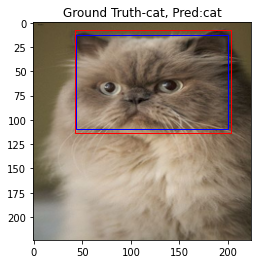

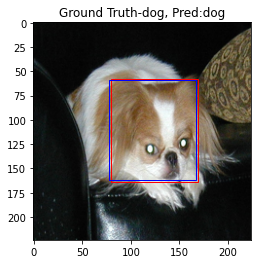

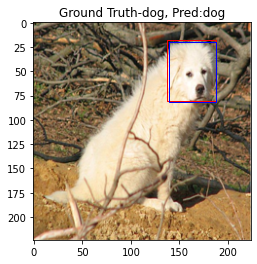

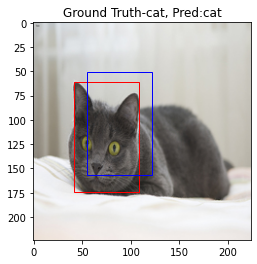

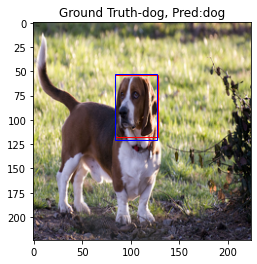

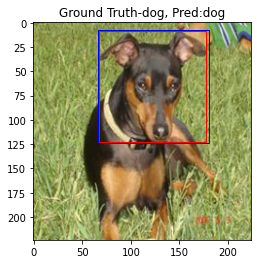

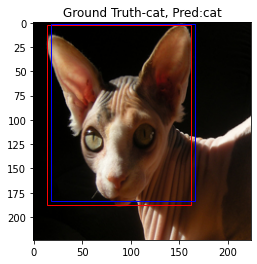

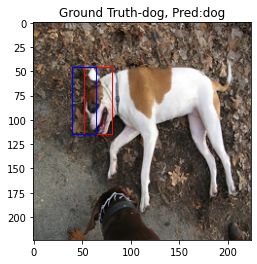

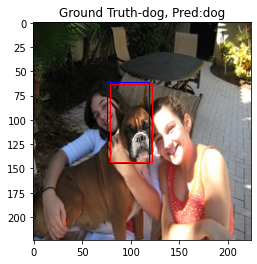

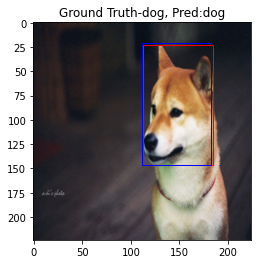

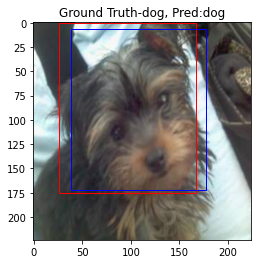

In [59]:
# 배치중 idx번째 것만 확인
idx = 4
num_imgs = validation_steps 
for val_data, val_gt in val_dataset.take(num_imgs):
    
   
    gt_cls_name = np.where(val_gt[:, 0]==0, 'dog', 'cat')
    
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    # target bbox (red)
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)    
    
    prediction = saved_model2.predict(val_data)
    
    pred_cls_idx = np.argmax(prediction[:, :2], axis=-1)
    pred_cls_name = np.where(pred_cls_idx==0, 'dog', 'cat')
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    # prediction bbox (blue)
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    plt.title(f'Ground Truth-{gt_cls_name[idx]}, Pred:{pred_cls_name[idx]}')
    
    plt.imshow(val_data[idx])
    plt.show()

### IoU 계산

In [62]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):    
    flag = (i == validation_steps-1)
    x = val_gt[:, 1]
    y = val_gt[:, 2]
    w = val_gt[:, 3]
    h = val_gt[:, 4]

    prediction = saved_model2.predict(val_data)
    
    pred_x = prediction[:, 2]
    pred_y = prediction[:, 3]
    pred_w = prediction[:, 4]
    pred_h = prediction[:, 5]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag = False
                break          
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)
 
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin
 
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
 
        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))
        avg_iou += iou / N_VAL
        
print(avg_iou)

0.8268428045035393


# 새로운 Image로 Test하기

In [60]:
from PIL import Image
image = Image.open('dog.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.
image = image[np.newaxis, ...]
print(image.shape)

(1, 224, 224, 3)


cat


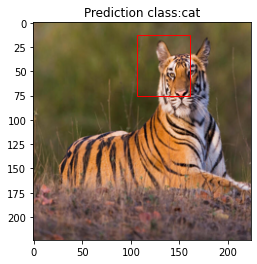

In [61]:
# 예측 결과 확인 - bounding box, class
from matplotlib.patches import Rectangle
prediction = saved_model2.predict(image)
pred_cls = np.where(np.argmax(prediction[0,:2], axis=-1)==0, 'dog', 'cat')
print(pred_cls)
pred_x = prediction[0,2]
pred_y = prediction[0,3]
pred_w = prediction[0,4]
pred_h = prediction[0,5]
pred_xmin = pred_x - pred_w/2.
pred_ymin = pred_y - pred_h/2.
pred_rect_x = int(pred_xmin * IMG_SIZE)
pred_rect_y = int(pred_ymin * IMG_SIZE)
pred_rect_w = int(pred_w * IMG_SIZE)
pred_rect_h = int(pred_h * IMG_SIZE)

pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                       fill=False, color='red')
plt.axes().add_patch(pred_rect)

import matplotlib.pyplot as plt
plt.imshow(image[0])
plt.title(f'Prediction class:{pred_cls}')
plt.show()